# The Shooting Method
The idea behind the shooting method is pretty simple. Want to solve a boundary value problem? Guess and refine the initial value to get to the other boundary!

For example, consider the second order boundary problem
$$ \begin{cases} u''(x) = f(u, u', t) \\ u(0) = u_0, u(1) = u_1 \end{cases} $$
Then the problem is equivalent to the following equation:
$$ F_x(1) - u_1 = 0 $$
where $F_x$ is the solution to the initial value problem
$$ \begin{cases} u''(x) = f(u, u', t) \\ u(0) = u_0, u'(0) = x \end{cases} $$

## Implementation
An implementation of the shooting method consists of the following two parts:
1. An IVP solver
2. A nonlinear equation solver (root finder)
We will let the user provide the IVP solver. It would be fair to let the user provide the root finder too, since a fixed root finding algorithm might take the initial value to areas where the IVP does not have a solution. But that complicates the solution a little bit.

In [ ]:
using BoundaryValueDiffEq, NLsolve

function Shoot(prob::BVProblem, alg::DEAlgorithm; kwargs...)
    bc = prob.bc
    u0 = copy(prob.u0)
    # The following will be zero when the BC is met
    loss = function (F, x)
        tmp_prob = ODEProblem(prob.f,x,prob.tspan) # IVP starting at x
        sol = solve(tmp_prob,alg;kwargs...)
        bc(F,sol,sol.prob.p,sol.t)
        nothing
    end
    result = nlsolve(loss, u0) # solve for hitting!
    sol_prob = ODEProblem(prob.f,result.zero,prob.tspan)
    sol = solve(sol_prob, alg;kwargs...)
end

## Advantages
1. It's very simple to implement!
2. It uses standard IVP solvers to solve the problem.

# A Simple Problem
We will first play with the simple pendulum:
$$ \ddot{\theta} + {1 \over L} (\alpha \dot{\theta} + g sin(\theta)) = 0 $$
In which $L$ is the length of the rod, $\theta$ is the angle, and $g$ is the gravity acceleration. It can be converted to the first degree form as follows:
$$ \begin{cases} \dot{\theta} = \varphi \\ \dot{\varphi} = -{1 \over L} (\alpha \varphi + g sin(\theta)) \end{cases} $$

The following code demonstrates how to define and solve this problem using [DifferentialEquations.jl](http://juliadiffeq.org/):

In [ ]:
using OrdinaryDiffEq, Plots; plotly()

const g = 9.81
L = 1.0
α = 0.5

function simplependulum!(du,u,p,t)
    θ  = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(1/L)*(g*sin(θ) + α*dθ)
end

u₀_2 = [-1.6, -1.7] # the initial guess

function spbc!(residual, sol, p, t)
    residual[1] = sol(0)[1] - 1
    residual[2] = sol(pi)[1]
end

spbvp = BVProblem(simplependulum!, spbc!, u₀_2, (0.0, 10))
@time spsol = solve(spbvp, Shooting(Tsit5()))
plot(spsol)

Now let's solve the same problem using our own solver:

In [ ]:
@time myspsol = Shoot(spbvp, Tsit5())
plot(myspsol)

## Disadvantages
1. The resulting IVP might not have a soulution defined up to the second boundary.
2. The resulting IVP might not enjoy the same stability status as the BVP.
3. Boundary value problems on long intervals tend to be problematic.

We might turn a good problem into a bad one!

## A More Ill-Conditioned Problem
The Henon-Heiles System describes the motion of a star under the potential of a galactic center, when we restrict the motion to a plane. The following is a first-degree form of the problem:
$$ \begin{cases} \dot{x} = p_x \\ \dot{y} = p_y \\ \dot{p_x} =  -x - 2\lambda xy \\ \dot{p_y} = -y - \lambda(x^2 - y^2) \end{cases} $$
The potential looks like this:


Picture is courtesy of Wikipedia.

In [ ]:
using DifferentialEquations

λ = 1.
henonheiles! = @ode_def HenonHeiles begin
    dx = p
    dy = q
    dp = -x - 2λ*x*y
    dq = -y - λ*(x^2 - y^2)
end

The problem behaves well when the solution is bounded and stays near the galactic center (the origin). But then the star escapes the gravity, the solutions tend to go nasty and mess with the numerical methods. The next piece of code displays a rather well-behaved solution of the problem:

In [ ]:
u0 = [0., .1, .5, 0.]
tspan = (0., 200.)

hhivp = ODEProblem(henonheiles!, u0, tspan)
hhivsol = solve(hhivp)
plot(hhivsol, vars=(1, 2))

Beautiful! Isn't it?

### A Sane BVP for Henon-Heiles System
Here we will use a poin on the example above to obtain a boundary value problem. This should be well-behaved and the shooting method shouldn't have a problem solving it.

In [ ]:
condition = hhivsol(10.)

function hhgoodbc!(res, sol, p, t)
    res[1] = sol(0)[1]
    res[2] = sol(0)[2] - 0.1
    res[3] = sol(10.)[3] - condition[3]
    res[4] = sol(10.)[4] - condition[4]
end

hhgoodbvp = BVProblem(henonheiles!, hhgoodbc!, [.0, .1, .1, 0.], tspan)
hhgoodbvsol = Shoot(hhgoodbvp, Tsit5())
hhgoodbvsol(10.)  - hhivsol(10.)

In [ ]:
plot(hhgoodbvsol, vars=(1, 2))

Looks good, with the mixed boundary condition. But let's take a look at the Dirichlet boundary condition:

In [ ]:
function hhdirbc!(res, sol, p, t)
    res[1] = sol(0)[1]
    res[2] = sol(0)[2] - 0.1
    res[3] = sol(10.)[1] - condition[1]
    res[4] = sol(10.)[2] - condition[2]
end

hhgoodbvp = BVProblem(henonheiles!, hhdirbc!, [.0, .1, .5, .1], tspan)
hhdirbvsol = Shoot(hhgoodbvp, Tsit5())
hhdirbvsol(10.)  - hhivsol(10.)

In [ ]:
plot(hhdirbvsol, vars=(1, 2))

This looks bad! Very bad! Let's try to see what goes wrong in the case of one of the bad guesses.

In [ ]:
badprob = ODEProblem(henonheiles!, [0., .1, .5, .5], (0.0, 12))
badsol = solve(badprob, Tsit5())
plot(badsol)

## Interval Length
We will first test the method on short intervals with the Henon-Heiles problem:

In [ ]:
condition = hhivsol(1.)

function hhshortbc!(res, sol, p, t)
    res[1] = sol(0)[1]
    res[2] = sol(0)[2] - 0.1
    res[3] = sol(1.)[1] - condition[1]
    res[4] = sol(1.)[2] - condition[2]
end

hhshortbvp = BVProblem(henonheiles!, hhshortbc!, [.0, .1, .1, 0.], tspan)
hhshortbvsol = Shoot(hhshortbvp, Tsit5())
hhshortbvsol(10.)  - hhivsol(10.) # testing on 10, despite the fact the condition is on 1.

In [ ]:
plot(hhshortbvsol, vars=(1, 2))

So let's try on a long interval with the well-behaved simple pendulum problem:

In [ ]:
spivp = ODEProblem(simplependulum!, u₀_2, (0.0, 20))
sipsol = solve(spivp)
plot(sipsol)

In [ ]:
condition = sipsol(15.)

function splongbc!(res, sol, p, t)
    res[1] = sol(0)[1] - u₀_2[1]
    res[2] = sol(15.)[1] - condition[1]
end

spbvplong = BVProblem(simplependulum!, splongbc!, [0.0, 0.0], (0.0, 20))
spsollong = solve(spbvplong, Shooting(Tsit5()))
spsollong(20.) - sipsol(20.)

In [ ]:
plot(spsollong)

Works well on this problem, even on a longer interval!

## Where to Find All This?
https://gitlab.com/omidmnz/ShootingMethod
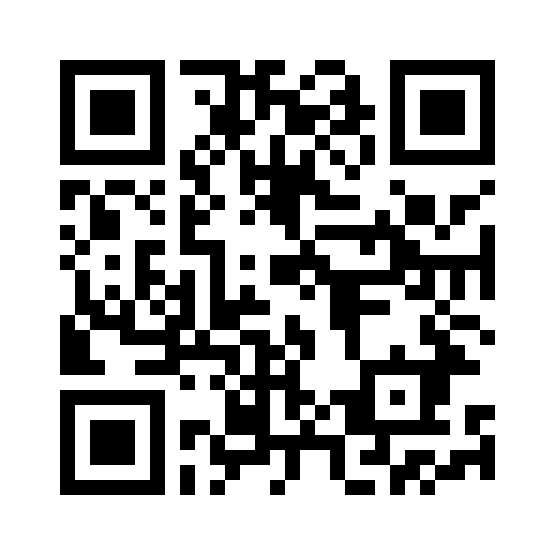